## Flood Health Vulnerability (FHV) Assessment 1
This notebook just updates the correlation figure according to the reviewer's comment.

In [3]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# Division
shape1 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm1_bbs_20180410.shp')
# ------------------------------------------------- #

In [4]:
# Load data
data = pd.read_hdf('./data/data.hdf')
data_dist = pd.read_hdf('./data/data_dist.hdf')
data_table = pd.read_hdf('./data/data_table.hdf')

# Name change
name_change = {'PAGEWEAK': 'P_WEAK-AGE', 
               'PFEMALE': 'P_FEMALE', 
               'PDISABL': 'P_DISABLE',
               'PRURAL': 'P_RURAL', 
               'PWEAKBUILT': 'P_WEAK-HOUSE',
               'PNOWATER': 'P_WATER-SUPPLY', 
               'PNOSANITARY': 'P_SANITATION', 
               'PNOELEC': 'P_ELECTRICITY',
               'PLITERACY': 'P_LITERACY',
               'PETHNIC': 'P_ETHNIC',
               'PRENT': 'P_RENT',
               'PNOPRIEDU': 'P_EDUCATION', 
               'PPOOR': 'P_POOR',
               'PAGRICULT': 'P_AGRICULTURE', 
               'PNOEMPLOY': 'P_EMPLOYMENT',
               'PDISEASE': 'P_DISEASE', 
               'PDIARRHEA': 'P_DIARRHEA', 
               'PDISEASEDWATER': 'P_WATER-DISEASE', 
               'NHOSPITALBED': 'N_HOSPITAL-BED',
               'NPHYSICIAN': 'N_PHYSICIAN', 
               'PAFFTHOUS': 'P_HOUSE-AFFECTED', 
               'PNOSCHOOL': 'P_CHILD-SCHOOL', 
               'PNOPREPARED': 'P_PREPAREDNESS',
               'PPERCEPTION': 'P_PERCEPTION', 
               'PSUPPORT': 'P_SUPPORT', 
               'DAMAGERATIO': 'R_DAMAGE-INCOME'}
data_table = data_table.replace(name_change)
data = data.rename(columns=name_change)
data_dist = data_dist.rename(columns=name_change)

# Add a dot to the district variables
name_dot = data_table['Name'].copy()
name_dot[data_table['Scale'] == "District"] = name_dot[data_table['Scale'] == "District"] + '*'

# Label short names
data_table_temp = data_table.copy()
data_table_temp['Domain'] = data_table_temp['Domain'].replace({'Demographic':'DEMO', 
                                                               'Health':'HEALTH',
                                                               'Social':'SOCIAL',
                                                               'Adaptive Capacity':'COPING CAPACITY',
                                                               'Economic':'ECON',
                                                               'Built':'BUILT'})
data = data[data_table['Name']]

# Re-group to three groups
data_table['Domain'] = data_table['Domain'].replace({'Demographic':'SOCIO-ECONOMIC', 
                                                     'Built':'SOCIO-ECONOMIC', 
                                                     'Social':'SOCIO-ECONOMIC',
                                                     'Economic':'SOCIO-ECONOMIC',
                                                     'Health':'HEALTH',
                                                     'Adaptive Capacity':'COPING CAPACITY'})
domains = data_table['Domain'].unique()
ndm = len(domains)
nvar = np.array([(data_table['Domain'] == dm).sum() for dm in domains])
ndist = data.shape[0]

### (1) Correlation Matrix

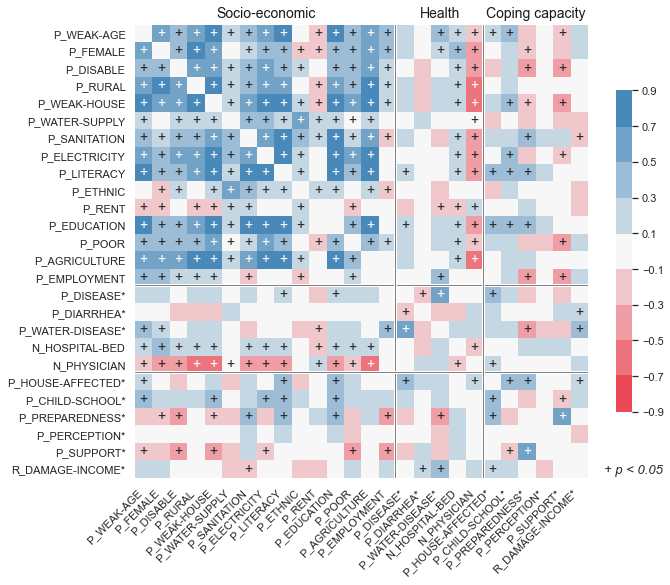

./figures/corrmat_new.pdf is saved.


In [5]:
# Correlation Matrix and P-value
corrmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
corrmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# P-value symbols
pvalsym = pd.DataFrame(index=corrmat.index, data=np.full(corrmat.shape, ''), 
                       columns=corrmat.columns)
pvalsym[pvalmat <= 0.05] = '+'
pvalsym_dist = pd.DataFrame(index=corrmat_dist.index, data=np.full(corrmat_dist.shape, ''), 
                            columns=corrmat_dist.columns)
pvalsym_dist[pvalmat_dist <= 0.05] = '+'
# - Replace Upazila correaltions to District correlation for district-level variables
index = data_table[data_table['Scale'] == 'District'].index
corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
corrmat[np.eye(len(corrmat)).astype('bool')] = 0
pvalsym.iloc[index,:] = pvalsym_dist.iloc[index,:]
pvalsym.iloc[:,index] = pvalsym_dist.iloc[:,index]
pvalsym[np.eye(len(pvalsym)).astype('bool')] = ''
# - Replace name_dot
corrmat.columns = name_dot; corrmat.index = name_dot
corrmat.index.name = ''
corrmat.columns.name = ''

# Plotting
sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 240, l=55, n=9)
cmap[4] = (0.97,0.97,0.97)
# cmap = sns.color_palette(palette='bwr_r', n_colors=9, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-0.9, vmax=0.9, center=0,
                 annot=pvalsym, fmt='', annot_kws={"size": 14, 'ha':'center',"va":'center'},
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5, 'ticks':np.arange(-0.9,1,0.2)})   # [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]})

# Domains
sources = np.array(data_table_temp['Domain'].tolist())
sources[np.isin(np.array(sources), ['DEMO','BUILT','SOCIAL','ECON'])] = 'SOCIO-ECONOMIC'
sources = list(sources)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        # Domain lines
        ax.axhline(i-0.05, c="w", lw=3)
        ax.axhline(i-0.05, c="grey", lw=1)
        ax.axvline(i-0.05, c="w", lw=3)
        ax.axvline(i-0.05, c="grey", lw=1)
    if source != sources[i - 1]:
        # Domain names
        lx = np.arange(len(corrmat))[np.isin(sources, source)]        
        ax.annotate(source.capitalize(), [np.median(lx)+0.5, -0.4], 
                    xycoords='data', annotation_clip=False,
                    color='k', ha='center', fontfamily='sans-serif', fontsize=14)
        
ax.annotate('+ p < 0.05', [1.1,0.01], xycoords= 'axes fraction',ha='center', fontfamily='sans-serif', fontsize=13, style='italic')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.tight_layout()
plt.show()

# Save a figure
if True:
    fn_save = './figures/corrmat_new.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

In [6]:
temp = data_table.copy()
temp.rename(columns={'Name': 'Name_after'}, inplace=True)
temp['Name_before'] = name_change.keys()
temp[['Name_before','Name_after']]

,Name_before,Name_after
0,PAGEWEAK,P_WEAK-AGE
1,PFEMALE,P_FEMALE
2,PDISABL,P_DISABLE
3,PRURAL,P_RURAL
4,PWEAKBUILT,P_WEAK-HOUSE
5,PNOWATER,P_WATER-SUPPLY
6,PNOSANITARY,P_SANITATION
7,PNOELEC,P_ELECTRICITY
8,PLITERACY,P_LITERACY
9,PETHNIC,P_ETHNIC
